# Application to data from the Goias Alkaline Province

This notebook generates the results and figures for section "Application to field data".

----

### Note
This is an [IPython notebook](http://ipython.org/notebook.html), a document that incorporates text, results, figures, and the [Python](http://www.python.org/) source code to produce them. If you are viewing this from the URL http://nbviewer.ipython.org/, the document will be static (not executable). To run the code, you will need to download the notebook and install the software required. See the instructions at https://github.com/pinga-lab/Total-magnetization-of-spherical-bodies.

These numerical tests use the open-source Python toolkit for geophysical modeling and inversion [Fatiando a Terra](http://fatiando.org/).

----

## Setup

First, we'll import the required libraries and define some functions needed for error propagation.

In [1]:
%matplotlib inline

In [2]:
import numpy
import scipy
from scipy import sparse
import fatiando
from fatiando import mesher, gridder, gravmag, utils
from fatiando.gravmag import sphere, fourier
from fatiando.gravmag.euler import Classic, ExpandingWindow
from fatiando.gravmag.eqlayer import PELTotalField, PELSmoothness, ncoeffs
from fatiando.inversion.regularization import Damping
from fatiando.utils import vec2ang, ang2vec
from fatiando.vis import mpl
from fatiando.vis.mpl import colors
from fatiando.gravmag.magdir import DipoleMagDir

In [3]:
print('Using Fatiando a Terra version {}'.format(fatiando.__version__))

Using Fatiando a Terra version 0.3


In [3]:
mpl.rcParams['font.size'] = 14

In [4]:
def uncertainty_L1(sigmad, solver):
    '''
    Calculate the uncertainty of the estimated
    intensities, inclinations and declinations
    obtained via L1 norm
    
    Parameters:
    
    * sigmad: float
        The uncertainty of the observed total field anomaly
        at all points.
    * solver: class:`fatiando.gravmag.magdir.DipoleMagDir`
        This class estimates the Cartesian components of the 
        magnetization vector of homogeneous dipolar bodies 
        with known center.

    Returns:
    
    * dh: list of arrays
        The uncertainties propagated from the observed data 
        to the estimated intensities, inclinations and 
        declinations of the magnetization vector of each 
        dipole.
    '''
    w = numpy.abs(solver.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1.0/w
    W = scipy.sparse.diags(w, 0)
    H = numpy.linalg.inv((solver.jacobian(p=None).T*W).dot(solver.jacobian(p=None))).dot(solver.jacobian(p=None).T)
    H = H*W
    dp = numpy.sqrt(numpy.diagonal((sigmad**2)*H.dot(H.T)))
    dp = numpy.reshape(dp, (solver.ndipoles, 3))
    dh = []
    dhj = numpy.zeros(3)
    pj = numpy.zeros(3)
    i = 0
    for pj in numpy.reshape(solver.p_, (solver.ndipoles, 3)):
        aux0 = pj[0]**2 + pj[1]**2
        aux1 = numpy.sqrt(aux0)
        aux2 = 1.0/aux0
        aux3 = 1.0/aux1
        aux4 = 1.0/solver.estimate_[i][0]
        dQx, dQy, dQz = (pj*aux4)
        dIx = pj[0]*(-pj[2]*(aux4**2)*aux3)
        dIy = pj[1]*(-pj[2]*(aux4**2)*aux3)
        dIz = aux1*(aux4**2)
        dDx = -pj[1]*aux2
        dDy = pj[0]*aux2
        dhj[0] = (dQx*dp[i][0])**2 + (dQy*dp[i][1])**2 + (dQz*dp[i][2])**2
        dhj[1] = (dIx*dp[i][0])**2 + (dIy*dp[i][1])**2 + (dIz*dp[i][2])**2
        dhj[2] = (dDx*dp[i][0])**2 + (dDy*dp[i][1])**2
        dhj = numpy.sqrt(dhj)
        dh.append(dhj)
        i = i+1
    return dh

def uncertainty_L2(sigmad, solver):
    '''
    Calculate the uncertainty of the estimated
    intensities, inclinations and declinations
    obtained via L2 norm
    
    Parameters:
    
    * sigmad: float
        The uncertainty of the observed total field anomaly
        at all points.
    * solver: class:`fatiando.gravmag.magdir.DipoleMagDir`
        This class estimates the Cartesian components of the 
        magnetization vector of homogeneous dipolar bodies 
        with known center.

    Returns:
    
    * dh: list of arrays
        The uncertainties propagated from the observed data 
        to the estimated intensities, inclinations and 
        declinations of the magnetization vector of each 
        dipole.
    '''
    dp = numpy.sqrt(numpy.diagonal((sigmad**2)*numpy.linalg.inv(solver.jacobian(p=None).T.dot(solver.jacobian(p=None)))))
    dp = numpy.reshape(dp, (solver.ndipoles, 3))
    dh = []
    dhj = numpy.zeros(3)
    pj = numpy.zeros(3)
    i = 0
    for pj in numpy.reshape(solver.p_, (solver.ndipoles, 3)):
        aux0 = pj[0]**2 + pj[1]**2
        aux1 = numpy.sqrt(aux0)
        aux2 = 1.0/aux0
        aux3 = 1.0/aux1
        aux4 = 1.0/solver.estimate_[i][0]
        dQx, dQy, dQz = (pj*aux4)
        dIx = pj[0]*(-pj[2]*(aux4**2)*aux3)
        dIy = pj[1]*(-pj[2]*(aux4**2)*aux3)
        dIz = aux1*(aux4**2)
        dDx = -pj[1]*aux2
        dDy = pj[0]*aux2
        dhj[0] = (dQx*dp[i][0])**2 + (dQy*dp[i][1])**2 + (dQz*dp[i][2])**2
        dhj[1] = (dIx*dp[i][0])**2 + (dIy*dp[i][1])**2 + (dIz*dp[i][2])**2
        dhj[2] = (dDx*dp[i][0])**2 + (dDy*dp[i][1])**2
        dhj = numpy.sqrt(dhj)
        dh.append(dhj)
        i = i+1
    return dh

In [5]:
# Geomagnetic Field according to the 11th generation of the International Geomagnetic 
# Reference Field (IGRF). The field was calculated for 2004.62, in the geodetic coordinates 
# latitude -16.17, longitude -51.20 and hight 800 m
inc_geo, dec_geo = -19.5, -18.5

# Load the digitalized data
DATA = numpy.loadtxt("GoiasAlkalineProvince.txt", skiprows=1)
Y = DATA[:,0]
X = DATA[:,1]
Z = -DATA[:,2]
TF = DATA[:,5]
LONGITUDE = DATA[:,6]
LATITUDE = DATA[:,7]

In [6]:
AREA = [min(X), max(X), min(Y), max(Y)]

DX = AREA[1] - AREA[0]
DY = AREA[3] - AREA[2]

NPTOS = 60

TF_min = numpy.min(TF)
TF_max = numpy.max(TF)

SHAPE = ((int)(NPTOS*(DX/DY)),NPTOS)

outcrops = [[-51.2527,-16.1868], 
            [-51.2578,-16.1936], 
            [-51.2837,-16.1847],
            [-51.4052,-16.0597],
            [-51.2619,-16.1025],
            [-51.2420,-16.0667],
            [-51.2523,-16.0466],
            [-51.2920,-16.0240]]
cities = [[-51.2552,-16.2328],
          [-51.3960,-16.0034]]
anomaly = [[-51.2034,-16.1668]]

Z_mean = numpy.mean(Z)
print Z_mean

-565.33312231


c:\Anaconda\lib\site-packages\matplotlib\figure.py:1644: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


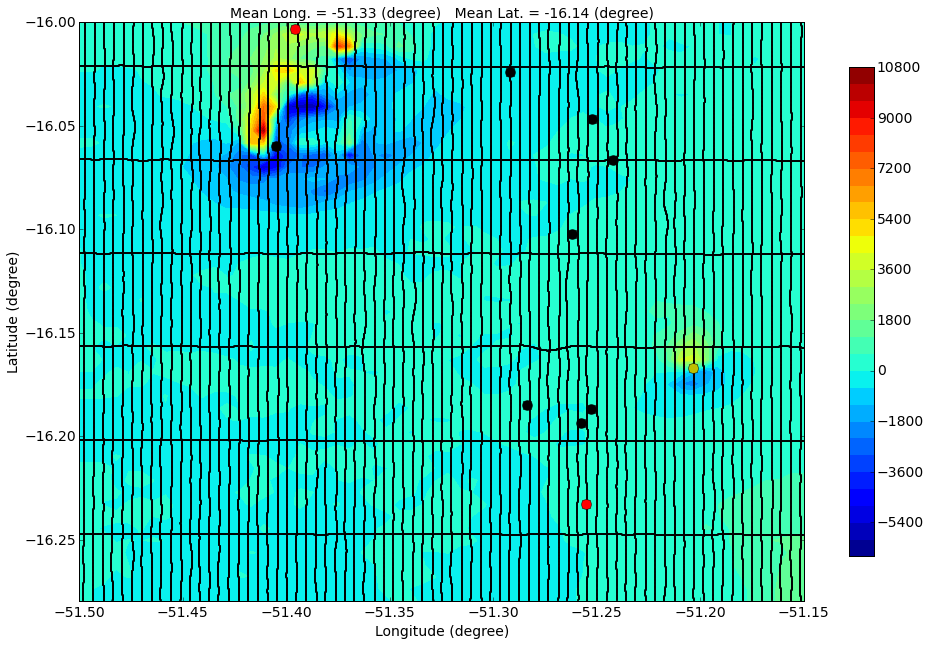

In [7]:
# Plot the observed data in longitude and latitude

mean_LONGITUDE = numpy.mean(LONGITUDE)
mean_LATITUDE = numpy.mean(LATITUDE)
title = 'Mean Long. = %.2f (degree)   Mean Lat. = %.2f (degree)' % (mean_LONGITUDE, 
                                                                    mean_LATITUDE)
mpl.close('all')
mpl.figure(figsize=(14, 14), tight_layout = True)
mpl.axis('scaled')
mpl.title(title, fontsize = 14)
mpl.contourf(LONGITUDE, LATITUDE, TF, SHAPE, 30, interp=True, extrapolate=True)
mpl.colorbar(shrink = 0.5)
mpl.plot(LONGITUDE, LATITUDE, '.k', markersize = 1)
mpl.points(outcrops, style='ok', size=10)
mpl.points(cities, style='or', size=10)
mpl.points(anomaly, style='oy', size=10)
mpl.ylabel('Latitude (degree)', fontsize = 14)
mpl.xlabel('Longitude (degree)', fontsize = 14)
mpl.show()

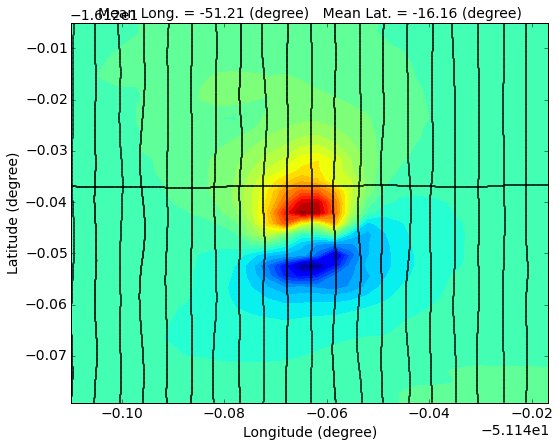

In [8]:
# Plot the observed data in longitude and latitude
# Only the Diorama Alkaline Complex

area_degree_Diorama = [-51.249994, -51.156775, -16.199155, -16.125]
longitude_Diorama, latitude_Diorama, data = gridder.cut(LONGITUDE, LATITUDE, 
                                                        [X, Y, Z, TF], area_degree_Diorama)
x_Diorama = data[0]
y_Diorama = data[1]
z_Diorama = data[2]
tf_Diorama = data[3]
mean_longitude = numpy.mean(longitude_Diorama)
mean_latitude = numpy.mean(latitude_Diorama)
title = 'Mean Long. = %.2f (degree)   Mean Lat. = %.2f (degree)' % (mean_longitude, 
                                                                    mean_latitude)

dx = area_degree_Diorama[1] - area_degree_Diorama[0]
dy = area_degree_Diorama[3] - area_degree_Diorama[2]
nptos = 30
shape_Diorama = ((int)(nptos*(dx/dy)),nptos)

area_Diorama = [min(x_Diorama), max(x_Diorama), min(y_Diorama), max(y_Diorama)]

mpl.close('all')
mpl.figure(figsize=(8, 8), tight_layout = True)
mpl.axis('scaled')
mpl.title(title, fontsize = 14)
mpl.contourf(longitude_Diorama, latitude_Diorama, tf_Diorama, shape_Diorama, 30, 
             interp=True, extrapolate=True)
mpl.plot(longitude_Diorama, latitude_Diorama, '.k', markersize = 1)
mpl.ylabel('Latitude (degree)', fontsize = 14)
mpl.xlabel('Longitude (degree)', fontsize = 14)
mpl.show()

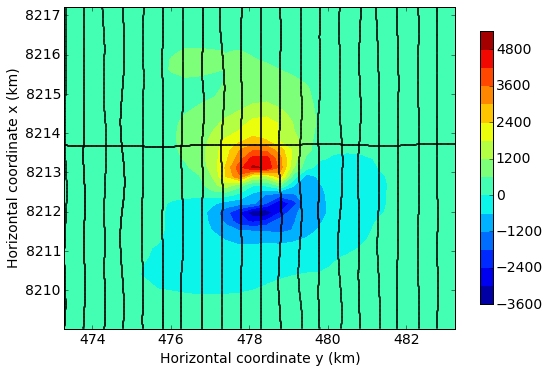

In [9]:
# Plot the observed data in UTM

mean_y = numpy.mean(y_Diorama)*0.001
mean_x = numpy.mean(x_Diorama)*0.001
title = 'Mean y = %.2f (km)   Mean x = %.2f (km)' % (mean_y, mean_x)
mpl.close('all')
mpl.figure(figsize=(8, 8), tight_layout = True)
mpl.axis('scaled')
#mpl.title(title, fontsize = 14)
mpl.contourf(y_Diorama, x_Diorama, tf_Diorama, shape_Diorama, 15, 
             interp=True, extrapolate=True)
mpl.colorbar(shrink = 0.5)
mpl.plot(y_Diorama, x_Diorama, '.k', markersize = 1)
mpl.ylabel('Horizontal coordinate x (km)', fontsize = 14)
mpl.xlabel('Horizontal coordinate y (km)', fontsize = 14)
mpl.m2km()
#mpl.savefig('TFA_Diorama.pdf', frameon=False, bbox_inches='tight')
mpl.savefig('TFA_Diorama.png', frameon=False, bbox_inches='tight')
mpl.show()

In [10]:
# Set the parameters of a Polynomial Equivalent Layer
N = len(x_Diorama)
Lx = numpy.max(x_Diorama) - numpy.min(x_Diorama)
Ly = numpy.max(y_Diorama) - numpy.min(y_Diorama)
Ls = 300.0
Qx = (int)(numpy.ceil((Lx/Ls)))
Qy = (int)(numpy.ceil((Ly/Ls)))
Q = Qx*Qy
m = (int)(numpy.ceil(numpy.sqrt(N/Q)))
z0 = max(z_Diorama) + 300.0
layer_Diorama = mesher.PointGrid(area_Diorama, z0, (Qy*m, Qx*m))
windows = (Qy, Qx)
alpha = 1
sdec = dec_geo
sinc = inc_geo

# The equivalent sources have induced magnetization
pel_Diorama = PELTotalField(x_Diorama, y_Diorama, z_Diorama, tf_Diorama, 
                            inc_geo, dec_geo, layer_Diorama, windows, alpha)
Tik1_Diorama = PELSmoothness(layer_Diorama, windows, alpha)
Tik0_Diorama = Damping(Q*ncoeffs(alpha))

In [11]:
fg = numpy.trace(pel_Diorama.hessian(p=None))
fr = numpy.trace(Tik1_Diorama.hessian(p=None))

print 'fg = %.5e' % fg
print 'fr = %.5e' % fr

fg = 3.65413e+05
fr = 2.49347e+18


In [12]:
solverpel_Diorama = (pel_Diorama + \
                     ((10**-1)*(fg/fr))*Tik1_Diorama + \
                     ((10**-10)*(fg/pel_Diorama.nparams))*Tik0_Diorama).fit()
layer_Diorama.addprop('magnetization', solverpel_Diorama.estimate_)

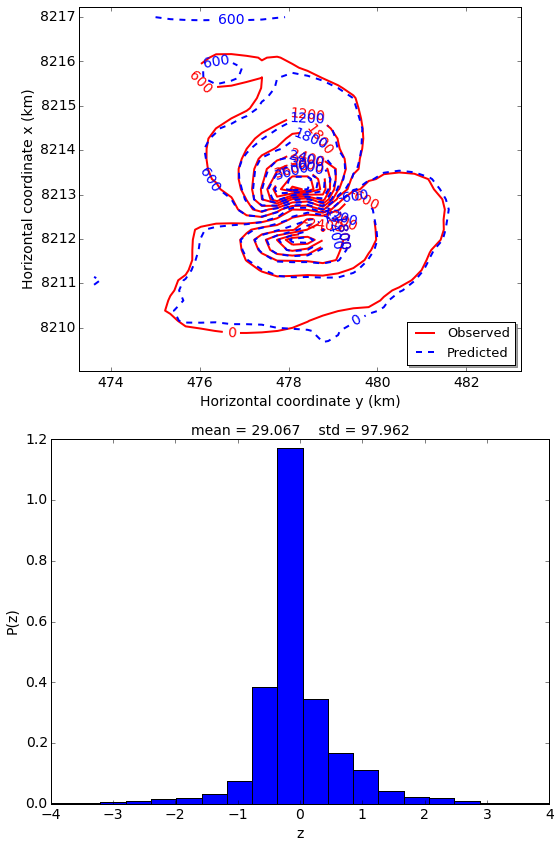

In [13]:
# Plot the PEL fit
mpl.close('all')
mpl.figure(figsize=(8, 12), tight_layout = True)
mpl.subplot(2, 1, 1)
mpl.axis('scaled')
nlevels = mpl.contour(y_Diorama, x_Diorama, tf_Diorama, shape_Diorama, 15, interp=True, color='r', 
                      label='Observed', clabel=True, style='solid', linewidth=2.0)
mpl.contour(y_Diorama, x_Diorama, solverpel_Diorama.predicted(), shape_Diorama, nlevels, interp=True,
            color='b', label='Predicted', clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='lower right', shadow=True, prop={'size':13})
mpl.ylabel('Horizontal coordinate x (km)', fontsize = 14)
mpl.xlabel('Horizontal coordinate y (km)', fontsize = 14)
mpl.m2km()
mpl.subplot(2, 1, 2)
residuals_mean = numpy.mean(solverpel_Diorama.residuals())
residuals_std = numpy.std(solverpel_Diorama.residuals())
s = (solverpel_Diorama.residuals() - residuals_mean)/residuals_std
smin = min(s)
smax = max(s)
nbins = ((smax-smin)/0.4)
mpl.hist(s, bins=nbins, range=None, normed=True, weights=None,
         cumulative=False, bottom=None, histtype='bar', align='mid',
         orientation='vertical', rwidth=None, log=False,
         color=None, label=None)
mpl.xlim(-4, 4)
mpl.title("mean = %.3f    std = %.3f" % (residuals_mean, residuals_std), fontsize = 14)
mpl.ylabel("P(z)", fontsize = 14)
mpl.xlabel("z", fontsize = 14)
mpl.show()

In [14]:
# Interpolate and Upward continuate the data

xi = layer_Diorama.x
yi = layer_Diorama.y
zi = numpy.ones_like(xi)*(-1000.0)

tf_Diorama_transformed = gravmag.sphere.tf(xi, yi, zi, layer_Diorama, inc_geo, dec_geo)

#numpy.savetxt('GoiasAlkalineProvince_continued.txt', numpy.vstack((yi, xi, zi, 
#                                                         tf_Diorama_transformed)).T)

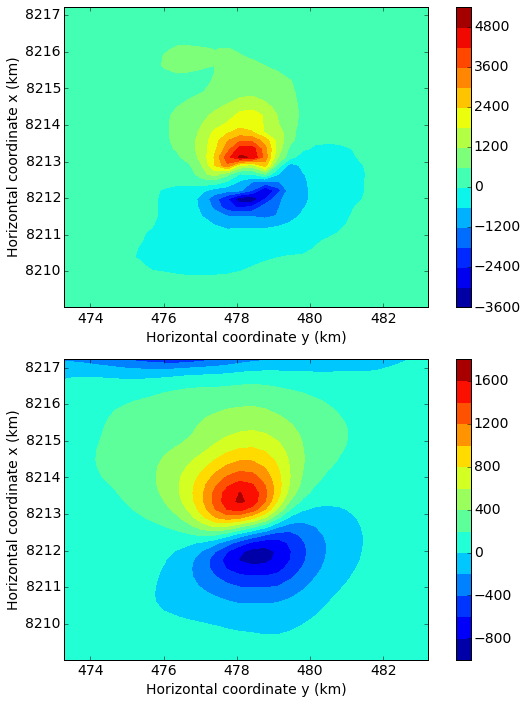

In [15]:
# Plot the observed data and the transformed data
mpl.close('all')
mpl.figure(figsize=(8, 10), tight_layout = True)
mpl.subplot(2, 1, 1)
mpl.axis('scaled')
#mpl.title('Observed Total Field anomaly (nT)')
mpl.contourf(y_Diorama, x_Diorama, tf_Diorama, shape_Diorama, 15, 
             interp=True, extrapolate=True)
mpl.colorbar()
mpl.ylabel('Horizontal coordinate x (km)', fontsize = 14)
mpl.xlabel('Horizontal coordinate y (km)', fontsize = 14)
mpl.m2km()
mpl.subplot(2, 1, 2)
mpl.axis('scaled')
#mpl.title('Transformed Total Field anomaly (nT)')
mpl.contourf(yi, xi, tf_Diorama_transformed, shape_Diorama, 15, 
             interp=True, extrapolate=True)
mpl.colorbar()
mpl.ylabel('Horizontal coordinate x (km)', fontsize = 14)
mpl.xlabel('Horizontal coordinate y (km)', fontsize = 14)
mpl.m2km()

#mpl.savefig('TFA_Diorama_Upward.pdf', frameon=False, bbox_inches='tight')
mpl.savefig('TFA_Diorama_Upward.png', frameon=False, bbox_inches='tight')

mpl.show()

In [16]:
# Pick the point for Euler Expanded Window scheme
#mpl.figure()
#mpl.title('Pick the centers of the expanding windows')
#mpl.axis('scaled')
#mpl.contourf(yi, xi, tf_transformed, shape, 15, interp=True)
#mpl.colorbar()
#centerseuler = mpl.pick_points(area, mpl.gca(), xy2ne=True)
# Estimate the centers with Euler deconvolution
#xderiv = gravmag.fourier.derivx(xi, yi, tf_transformed, layer.shape)
#yderiv = gravmag.fourier.derivy(xi, yi, tf_transformed, layer.shape)
#zderiv = gravmag.fourier.derivz(xi, yi, tf_transformed, layer.shape)
    
#euler = Classic(xi, yi, zi, tf_transformed, xderiv, yderiv, zderiv, 3)
# definir o tamanho máximo e mínimo das janelas
#sizes = numpy.linspace(1000, 8000, 20)
#results = [ExpandingWindow(euler, c, sizes).fit() for c in centerseuler]
#centersdipole = [r.estimate_ for r in results]

In [17]:
#print 'X Y Z'
#print centersdipole[0][0], centersdipole[0][1], centersdipole[0][2]

In [18]:
centersdipole = [[8212649.97369, 478365.278885, 663.263362513]]

In [19]:
estimates = []

In [20]:
# Estimate the magnetization vectors with the L2-norm
solverdipole = DipoleMagDir(xi, yi, zi, tf_Diorama_transformed, 
                            inc_geo, dec_geo, centersdipole).fit()

# Calculate the uncertainties
dh_L2 = uncertainty_L2(5.0, solverdipole)

# Print the estimated parameters
print 'Estimated L2'
for e in solverdipole.estimate_:
    print '%12.5f %12.5f' % (e[1], e[2])
    estimates.append(e)
print 'Uncertainties L2'
for dhj in dh_L2:
    print '%12.5f %12.5f' % (dhj[1], dhj[2])

Estimated L2
   -69.25595    -16.22821
Uncertainties L2
     0.00013      0.00050


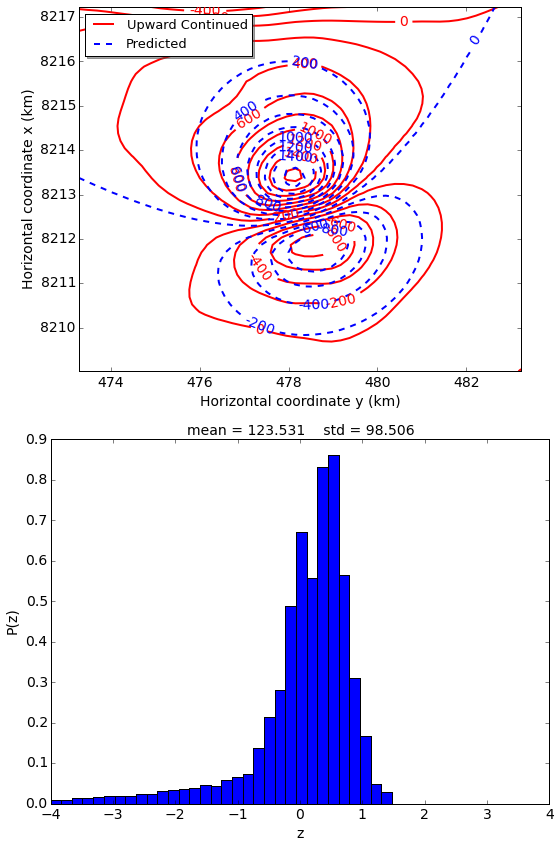

In [21]:
# Plot the fit and the normalized histogram of the residuals
mpl.close("all")
mpl.figure(figsize=(8, 12), tight_layout = True)
mpl.subplot(2, 1, 1)
#mpl.title("Total Field Anomaly (nT)", fontsize = 14)
mpl.axis('scaled')
nlevels = mpl.contour(yi, xi, tf_Diorama_transformed, (50,50), 15, interp=True, color='r', 
                      label='Upward Continued', clabel=True, style='solid', linewidth=2.0)
mpl.contour(yi, xi, solverdipole.predicted(), (50,50), nlevels, interp=True, color='b', 
            label='Predicted', clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='upper left', shadow=True, prop={'size':13})
mpl.ylabel('Horizontal coordinate x (km)', fontsize = 14)
mpl.xlabel('Horizontal coordinate y (km)', fontsize = 14)
mpl.m2km()
mpl.subplot(2, 1, 2)
residuals_mean = numpy.mean(solverdipole.residuals())
residuals_std = numpy.std(solverdipole.residuals())
s = (solverdipole.residuals() - residuals_mean)/residuals_std
mpl.hist(s, bins=51, range=None, normed=True, weights=None,
       cumulative=False, bottom=None, histtype='bar', align='mid',
       orientation='vertical', rwidth=None, log=False,
       color=None, label=None)
mpl.xlim(-4, 4)
mpl.title("mean = %.3f    std = %.3f" % (residuals_mean, residuals_std), fontsize = 14)
mpl.ylabel("P(z)", fontsize = 14)
mpl.xlabel("z", fontsize = 14)
mpl.show()

In [22]:
# Fit the data with a Polynomial Equivalent Layer
# and perform a pole reduction
# The incs and decs were obtained with the L2 approach

layer_Diorama_poleL2 = mesher.PointGrid(area_Diorama, z0, (Qy*m, Qx*m))

sinc_L2 = solverdipole.estimate_[0][1]
sdec_L2 = solverdipole.estimate_[0][2]

pel_Diorama_pole = PELTotalField(x_Diorama, y_Diorama, z_Diorama, tf_Diorama, 
                                 inc_geo, dec_geo, layer_Diorama_poleL2, 
                                 windows, alpha, sinc_L2, sdec_L2)

In [23]:
fg_pole = numpy.trace(pel_Diorama_pole.hessian(p=None))

In [24]:
solverpel_Diorama_poleL2 = (pel_Diorama_pole + \
                            ((10**-1)*(fg_pole/fr))*Tik1_Diorama + \
                            ((10**-10)*(fg_pole/pel_Diorama_pole.nparams))*Tik0_Diorama).fit()
layer_Diorama_poleL2.addprop('magnetization', 
                             utils.ang2vec(solverpel_Diorama_poleL2.estimate_, -90.0, 0.0))

In [25]:
# Calculate the reduced data at 1000 m above
tf_Diorama_RTPL2 = gravmag.sphere.tf(x_Diorama, y_Diorama, z_Diorama - 1000.0, 
                                     layer_Diorama_poleL2, -90., 0.)

In [26]:
# Estimate the magnetization vectors with the L1-norm
# by using the L2-norm as input
for i in range(30):
    w = numpy.abs(solverdipole.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1/w
    solverdipole.set_weights(w)
    solverdipole.fit()

# Calculate the uncertainties
dh_L1 = uncertainty_L1(5.0, solverdipole)
    
print 'Estimated L1'
for e in solverdipole.estimate_:
    print '%12.5f %12.5f' % (e[1], e[2])
    estimates.append(e)
print 'Uncertainties L1'
for dhj in dh_L1:
    print '%12.5f %12.5f' % (dhj[1], dhj[2])

Estimated L1
   -71.41751    -23.39541
Uncertainties L1
     0.00182      0.01049


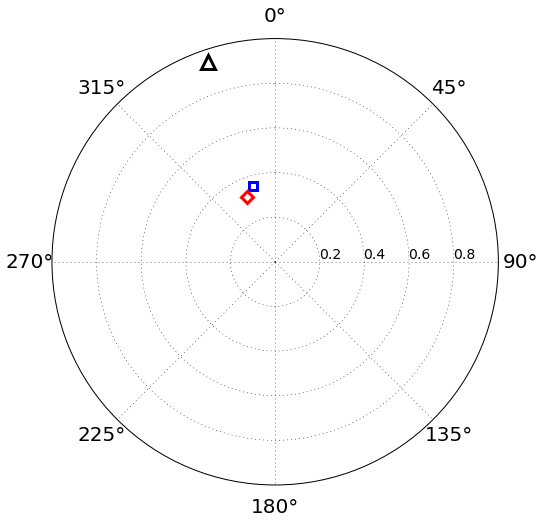

In [27]:
hg = numpy.sqrt((numpy.cos(numpy.deg2rad(inc_geo))*numpy.cos(numpy.deg2rad(dec_geo)))**2 + \
                (numpy.cos(numpy.deg2rad(inc_geo))*numpy.sin(numpy.deg2rad(dec_geo)))**2)

mpl.figure(figsize=(8,8))
ax = mpl.subplot(111, polar=True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')
ax.set_rgrids([0.2,0.4,0.6,0.8], angle=90.)
# direction of the Geomagnetic field
if inc_geo >= 0.0:
    mpl.plot(numpy.deg2rad(dec_geo), hg, marker='^', ms=14, 
             mec='k', mew=3, mfc='k', fillstyle='full')
else:
    mpl.plot(numpy.deg2rad(dec_geo), hg, marker='^', ms=14, 
             mec='k', mew=3, fillstyle='none')
# L2-norm estimates
he = numpy.sqrt((numpy.cos(numpy.deg2rad(estimates[0][1]))*numpy.cos(numpy.deg2rad(estimates[0][2])))**2 + \
                (numpy.cos(numpy.deg2rad(estimates[0][1]))*numpy.sin(numpy.deg2rad(estimates[0][2])))**2)
if estimates[0][1] >= 0.0:
    mpl.plot(numpy.deg2rad(estimates[0][2]), he, marker='s', ms=8, 
             mec='b', mew=3, mfc='b', fillstyle='full')
else:
    mpl.plot(numpy.deg2rad(estimates[0][2]), he, marker='s', ms=8, 
             mec='b', mew=3, fillstyle='none')
# L1-norm estimates
he = numpy.sqrt((numpy.cos(numpy.deg2rad(estimates[1][1]))*numpy.cos(numpy.deg2rad(estimates[1][2])))**2 + \
                (numpy.cos(numpy.deg2rad(estimates[1][1]))*numpy.sin(numpy.deg2rad(estimates[1][2])))**2)
if estimates[1][1] >= 0.0:
    mpl.plot(numpy.deg2rad(estimates[1][2]), he, marker='D', ms=8, 
             mec='r', mew=3, mfc='r', fillstyle='full')
else:
    mpl.plot(numpy.deg2rad(estimates[1][2]), he, marker='D', ms=8, 
             mec='r', mew=3, fillstyle='none')#c.set_alpha(1.0)
mpl.xticks(fontsize=20) # on the cicle
mpl.yticks(fontsize=14) # along the radial direction
mpl.ylim(0.0, 1.0)
mpl.savefig('stereo.png', dpi=600)
mpl.show()

In [28]:
# Fit the data with a Polynomial Equivalent Layer
# and perform a pole reduction
# The incs and decs were obtained with the L1 approach

layer_Diorama_poleL1 = mesher.PointGrid(area_Diorama, z0, (Qy*m, Qx*m))

sinc_L1 = solverdipole.estimate_[0][1]
sdec_L1 = solverdipole.estimate_[0][2]

pel_Diorama_pole = PELTotalField(x_Diorama, y_Diorama, z_Diorama, tf_Diorama, 
                                 inc_geo, dec_geo, layer_Diorama_poleL1, 
                                 windows, alpha, sinc_L1, sdec_L1)

In [29]:
fg_pole = numpy.trace(pel_Diorama_pole.hessian(p=None))

In [30]:
solverpel_Diorama_poleL1 = (pel_Diorama_pole + \
                            ((10**-1)*(fg_pole/fr))*Tik1_Diorama + \
                            ((10**-10)*(fg_pole/pel_Diorama_pole.nparams))*Tik0_Diorama).fit()
layer_Diorama_poleL1.addprop('magnetization', 
                             utils.ang2vec(solverpel_Diorama_poleL1.estimate_, -90.0, 0.0))

In [31]:
# Calculate the reduced data at 1000 m above
tf_Diorama_RTPL1 = gravmag.sphere.tf(x_Diorama, y_Diorama, z_Diorama - 1000.0, layer_Diorama_poleL1, -90., 0.)

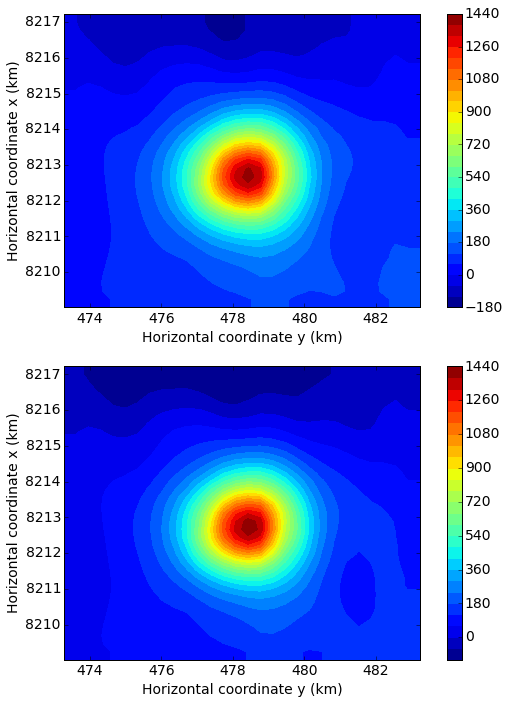

In [32]:
# Plot the reduced data
tol = 0.05
#smin = 0.001*numpy.min(x_Diorama)
#smax = 0.001*numpy.max(x_Diorama)
smin = numpy.min(x_Diorama)
smax = numpy.max(x_Diorama)
smin = smin - tol*(smax - smin)
smax = smax + tol*(smax - smin)
#tmin = 0.001*numpy.min(y_Diorama)
#tmax = 0.001*numpy.max(y_Diorama)
tmin = numpy.min(y_Diorama)
tmax = numpy.max(y_Diorama)
tmin = tmin - tol*(tmax - tmin)
tmax = tmax + tol*(tmax - tmin)

mpl.close('all')
mpl.figure(figsize=(8, 10), tight_layout = True)
#mpl.figure(figsize=(8, 10))

mpl.subplot(2, 1, 1)
mpl.axis('scaled')
#mpl.title('Reduced-to-the-pole anomaly (nT) - L2')
#mpl.contourf(0.001*y_Diorama, 0.001*x_Diorama, tf_Diorama_RTPL2, shape_Diorama, 30, interp=True, extrapolate=True)
mpl.contourf(y_Diorama, x_Diorama, tf_Diorama_RTPL2, shape_Diorama, 30, interp=True, extrapolate=True)
mpl.colorbar()
mpl.ylabel('Horizontal coordinate x (km)', fontsize = 14)
mpl.xlabel('Horizontal coordinate y (km)', fontsize = 14)
mpl.m2km()
#mpl.text(smin-tol*(smax-smin), tmin-tol*(tmax-tmin), '(a)', fontsize=16)

mpl.subplot(2, 1, 2)
mpl.axis('scaled')
#mpl.title('Reduced-to-the-pole anomaly (nT) - L1')
#mpl.contourf(0.001*y_Diorama, 0.001*x_Diorama, tf_Diorama_RTPL1, shape_Diorama, 30, interp=True, extrapolate=True)
mpl.contourf(y_Diorama, x_Diorama, tf_Diorama_RTPL1, shape_Diorama, 30, interp=True, extrapolate=True)
mpl.colorbar()
mpl.ylabel('Horizontal coordinate x (km)', fontsize = 14)
mpl.xlabel('Horizontal coordinate y (km)', fontsize = 14)
mpl.m2km()
#mpl.text(smin-tol*(smax-smin), tmin-tol*(tmax-tmin), '(b)', fontsize=16)

#mpl.savefig('TFA_Diorama_RTP.pdf', frameon=False, bbox_inches='tight')
mpl.savefig('TFA_Diorama_RTP.png', frameon=False, bbox_inches='tight')

mpl.show()

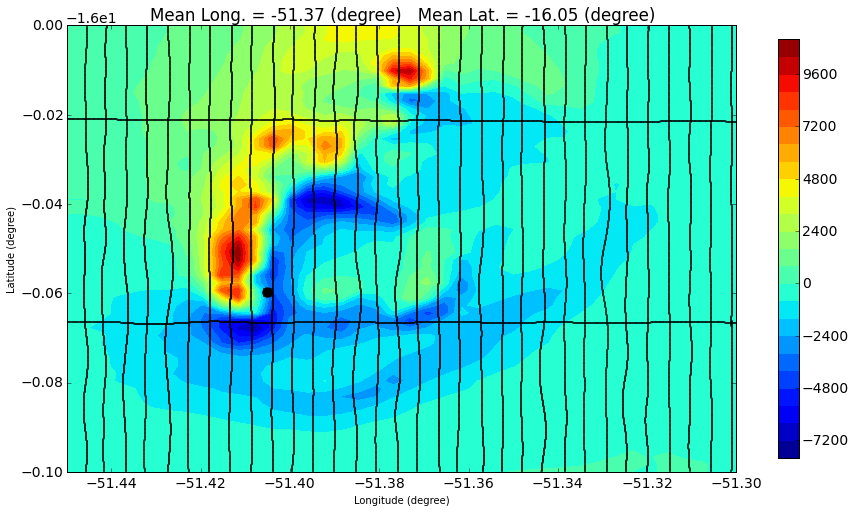

In [33]:
# Plot the observed data in longitude and latitude
# Montes Claros de Goiás (MCG)

area_degree_MCG = (-51.45, -51.30, -16.10, -16.00)
longitude_MCG, latitude_MCG, data = gridder.cut(LONGITUDE, LATITUDE, [X, Y, Z, TF], area_degree_MCG)
x_MCG = data[0]
y_MCG = data[1]
z_MCG = data[2]
tf_MCG = data[3]
mean_longitude = numpy.mean(longitude_MCG)
mean_latitude = numpy.mean(latitude_MCG)
title = 'Mean Long. = %.2f (degree)   Mean Lat. = %.2f (degree)' % (mean_longitude, mean_latitude)

dx = area_degree_MCG[1] - area_degree_MCG[0]
dy = area_degree_MCG[3] - area_degree_MCG[2]
nptos = 40
shape_MCG = ((int)(nptos*(dx/dy)),nptos)

area_MCG = [min(x_MCG), max(x_MCG), min(y_MCG), max(y_MCG)]

mpl.close('all')
mpl.figure(figsize=(15, 15))
mpl.axis('scaled')
mpl.title(title)
mpl.contourf(longitude_MCG, latitude_MCG, tf_MCG, shape_MCG, 30, interp=True, extrapolate=True)
mpl.plot(longitude_MCG, latitude_MCG, '.k', markersize = 1)
mpl.colorbar(shrink = 0.5)
mpl.points(outcrops, style='ok', size=10)
mpl.ylabel('Latitude (degree)', fontsize = 10)
mpl.xlabel('Longitude (degree)', fontsize = 10)
mpl.show()

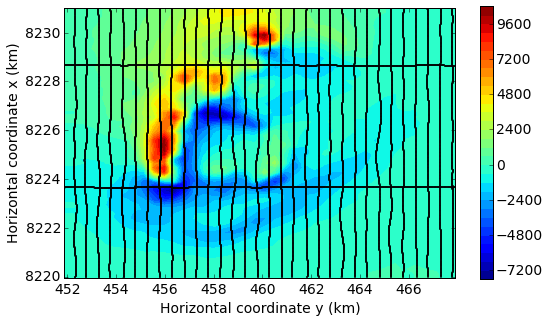

In [34]:
# Plot the observed data in UTM

mpl.close('all')
mpl.figure(figsize=(8, 8), tight_layout = True)
mpl.axis('scaled')
mpl.contourf(y_MCG, x_MCG, tf_MCG, shape_MCG, 30, interp=True, extrapolate=True)
mpl.colorbar(shrink = 0.5)
mpl.plot(y_MCG, x_MCG, '.k', markersize = 1)
mpl.ylabel('Horizontal coordinate x (km)', fontsize = 14)
mpl.xlabel('Horizontal coordinate y (km)', fontsize = 14)
mpl.m2km()
#mpl.savefig('TFA_MontesClarosGoias.pdf', frameon=False, bbox_inches='tight')
mpl.savefig('TFA_MontesClarosGoias.png', frameon=False, bbox_inches='tight')
mpl.show()

In [35]:
# Set the parameters of a Polynomial Equivalent Layer
N = len(x_MCG)
Lx = numpy.max(x_MCG) - numpy.min(x_MCG)
Ly = numpy.max(y_MCG) - numpy.min(y_MCG)
Ls = 300.0
Qx = (int)(numpy.ceil((Lx/Ls)))
Qy = (int)(numpy.ceil((Ly/Ls)))
Q = Qx*Qy
m = (int)(numpy.ceil(numpy.sqrt(N/Q)))
z0 = max(z_MCG) + 300.0
windows = (Qy, Qx)
alpha = 1

In [ ]:
# Construct a PEL with the magnetization direction obtained from L2 approach
layer_MCG_poleL2 = mesher.PointGrid(area_MCG, z0, (Qy*m, Qx*m))
pel_MCG_pole = PELTotalField(x_MCG, y_MCG, z_MCG, tf_MCG, inc_geo, dec_geo, layer_MCG_poleL2, 
                             windows, alpha, sinc_L2, sdec_L2)
Tik1_MCG = PELSmoothness(layer_MCG_poleL2, windows, alpha)
Tik0_MCG = Damping(Q*ncoeffs(alpha))

In [ ]:
fg = numpy.trace(pel_MCG_pole.hessian(p=None))
fr = numpy.trace(Tik1_MCG.hessian(p=None))

print 'fg = %.5e' % fg
print 'fr = %.5e' % fr

In [ ]:
solverpel_MCG = (pel_MCG_pole + \
                 ((10**-1)*(fg/fr))*Tik1_MCG + \
                 ((10**-10)*(fg/pel_MCG_pole.nparams))*Tik0_MCG).fit()
layer_MCG_poleL2.addprop('magnetization', 
                         utils.ang2vec(solverpel_MCG.estimate_, -90.0, 0.0))

In [ ]:
# Calculate the reduced data at 1000 m above
tf_MCG_RTPL2 = gravmag.sphere.tf(x_MCG, y_MCG, z_MCG - 1000.0, layer_MCG_poleL2, -90., 0.)

In [ ]:
# Construct a PEL with the magnetization direction obtained from L1 approach
layer_MCG_poleL1 = mesher.PointGrid(area_MCG, z0, (Qy*m, Qx*m))
pel_MCG_pole = PELTotalField(x_MCG, y_MCG, z_MCG, tf_MCG, inc_geo, dec_geo, layer_MCG_poleL1, 
                             windows, alpha, sinc_L1, sdec_L1)
#Tik1 = PELSmoothness(layer, windows, alpha)
#Tik0 = Damping(Q*ncoeffs(alpha))

In [ ]:
fg = numpy.trace(pel_MCG_pole.hessian(p=None))
fr = numpy.trace(Tik1_MCG.hessian(p=None))

print 'fg = %.5e' % fg
print 'fr = %.5e' % fr

In [ ]:
solverpel_MCG = (pel_MCG_pole + \
                 ((10**-1)*(fg/fr))*Tik1_MCG + \
                 ((10**-10)*(fg/pel_MCG_pole.nparams))*Tik0_MCG).fit()
layer_MCG_poleL1.addprop('magnetization', 
                         utils.ang2vec(solverpel_MCG.estimate_, -90.0, 0.0))

In [ ]:
# Calculate the reduced data at 1000 m above
tf_MCG_RTPL1 = gravmag.sphere.tf(x_MCG, y_MCG, z_MCG - 1000.0, layer_MCG_poleL1, -90., 0.)

In [ ]:
# Plot the reduced data
mpl.figure(figsize=(8, 10), tight_layout = True)
mpl.subplot(2, 1, 1)
mpl.axis('scaled')
#mpl.title('Reduced-to-the-pole anomaly (nT) - L2')
mpl.contourf(y_MCG, x_MCG, tf_MCG_RTPL2, shape_MCG, 30, interp=True, extrapolate=True)
mpl.colorbar(shrink = 0.9)
mpl.ylabel('Horizontal coordinate x (km)', fontsize = 14)
mpl.xlabel('Horizontal coordinate y (km)', fontsize = 14)
mpl.m2km()

mpl.subplot(2, 1, 2)
mpl.axis('scaled')
#mpl.title('Reduced-to-the-pole anomaly (nT) - L1')
mpl.contourf(y_MCG, x_MCG, tf_MCG_RTPL1, shape_MCG, 30, interp=True, extrapolate=True)
mpl.colorbar(shrink = 0.9)
mpl.ylabel('Horizontal coordinate x (km)', fontsize = 14)
mpl.xlabel('Horizontal coordinate y (km)', fontsize = 14)
mpl.m2km()

#mpl.savefig('TFA_MontesClarosGoias-RTP.pdf', frameon=False, bbox_inches='tight')
mpl.savefig('TFA_MontesClarosGoias-RTP.png', frameon=False, bbox_inches='tight')

mpl.show()